# Calibration

Modern integrated circuits, or chips, are manufactured using a complex process where the chips are essentially printed onto a silicon wafer (see this **[video](https://www.youtube.com/watch?v=g8Qav3vIv9s)** for an overview of the process). Each wafer contains many chips (e.g. a wafer with 300mm diameter fits several hundred laptop grade microprocessors). The chips on a finished wafer are tested to identify which are good and which are faulty. The yield of a wafer is determined by the fraction of good chips. To maximize the yield, semiconductor manufacturers are interested in identifying and correcting the causes of the faulty chips (e.g. wrong settings in one of processing steps). Some causes can be identified by visual inspection of patterns in a wafer maps, showing which chips are good and which are faulty.

![wafer.png](attachment:data/wafer.png)

In this assignment you will work with wafer map data from a semiconductor manufacturing process. Your task will be to develop a calibrated classifier for identifying patterns of faulty chips on a finished wafer. Identifying such patterns can help with optimizing the manufacturing process parameters for the following wafers.
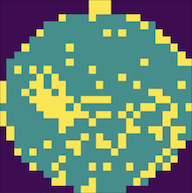

#### Deliverable

Throughout this notebook you will find cells starting with `#TODO` and `# // BEGIN_TODO`.

- Fill in all these TODO cells. The `#TODO` cells are meant to guide you (you are strongly encouraged to fill these in!), while the `# // BEGIN_TODO` _answer cells_ will be graded.
- Answer cells start and end with tags, `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]`, for example. Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- Be careful when importing additional libraries. The code for of your answers will be evaluated automatically and we cannot guarantee that any additional libraries will be available in that environment. Please check the Momotor output on Canvas after submitting the assignment, you should be able to see if all your code executed without errors. If in doubt, please ask your instructor.
- You can add arbitrary many code and text cells between the `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags to make your code nicely readable.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

At the end, deliver the filled in **and executed** `.ipynb` file by submitting it to the corresponding assignment on Canvas. You may submit as many times as you like before the deadline. The last submission counts.

> **IMPORTANT:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = 7
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [229]:
#// BEGIN_TODO [AUTHOR]
group_number = 27
name_student1 = "Enes Berkay Koca"
id_student1 = 1342517
name_student2 = "Konstantinos Chanioglou"
id_student2 = 2053705

#// END_TODO [AUTHOR]

## Import libraries

Later, the code in your answer cells will be evaluated in an environment with several typical data science libraries installed, including pandas, numpy, matplotlib, sklearn. You are free to use them.

> **IMPORTANT:** Please import any additional libraries inside your answer cells (otherwise your code may crash during evaluation).

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

## Load the data

The data resides in the `./data/wafer.pkl` pickle file. It is based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

In [231]:
with open('./data/wafer.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

`X` contains wafer maps and `y` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

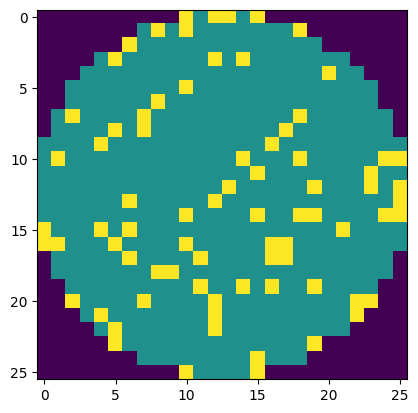

In [232]:
plt.imshow(X_train[0]);

The wafer maps were labeled by human experts according to bad chip patterns, where each label is an integer:

- 0: No pattern
- 1: Center
- 2: Donut
- 3: Edge-local
- 4: Edge-ring
- 5: Local
- 6: Near-full
- 7: Random
- 8: Scratch

An example of the wafer map for each pattern is shown below. Note that not all patterns may be present in this particular data set. 

{0: 3744, 1: 47, 3: 161, 5: 138, 6: 36, 7: 34}
{0: 1847, 1: 15, 3: 79, 5: 84, 6: 20, 7: 20}


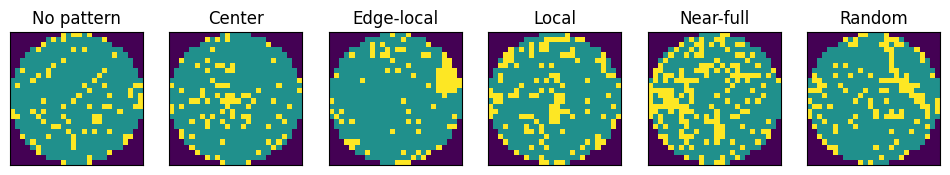

In [233]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Center", "Donut", "Edge-local", "Edge-ring", "Local", "Near-full", "Random", "Scratch"]
fig, axes = plt.subplots(1,len(unique_classes), figsize = (12,5))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

count_train = dict(zip(*np.unique(y_train, return_counts=True)))
count_test = dict(zip(*np.unique(y_test, return_counts=True)))

print(count_train)
print(count_test)

## Train a classifier

In this part you will implement a classifier, which will be used later for evaluating your calibration method.

First, start by exploring the data. Remember, you can add as many code and markdown cells as you like.

In [234]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4160, 26, 26) (2065, 26, 26) (4160,) (2065,)


In the first part of this assignment the aim is to identify whether the wafer map contains any known patterns or not. We therefore treat it as a binary classification problem and replace labels other than 0 to 1.

In [235]:
y_binary_train = np.copy(y_train)
y_binary_train[y_binary_train != 0] = 1

y_binary_test = np.copy(y_test)
y_binary_test[y_binary_test != 0] = 1

count_train = dict(zip(*np.unique(y_binary_train, return_counts=True)))
count_test = dict(zip(*np.unique(y_binary_test, return_counts=True)))

print(count_train)
print(count_test)


{0: 3744, 1: 416}
{0: 1847, 1: 218}


#### Step 1

Choose a metric for evaluating the classifier's generalization performance and assign your choice to a string variable `classifier_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `classifier_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently trained in a string variable `classifier_metric_decision` (max 400 characters).

In [236]:
#// BEGIN_TODO [STEP_1] Choose a classifier metric (1 point)

classifier_metric_choice = "Macro F1 Score"

classifier_metric_motivation = """Macro F1 Score is used as the metric because it is the harmonic mean of precision and recall. It is a good metric for imbalanced datasets, which is the case for this dataset. In our case, the training dataset has 3744 samples with class 0 and 416 samples with class 1.

For the model selection, we choose logistic regression bcs it's good for classification problems. The hyperparameters are found using grid search by extracting the hyperparameters from the best performing model (macro f1 score-wise).
"""



In [237]:
#// END_TODO [STEP_1]

#### Step 2

Train a binary classifier on the training set `X_train` and `y_binary_train`. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class (0 or 1) and the confidence estimate of the positive class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor.

Evaluate your trained model on the test set `X_test` and `y_binary_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimate in the variables `uncalibrated_y` and `uncalibrated_p`, respectively:

- `uncalibrated_y` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.int32`, where $N$ is the number of samples and each value is the predicted class,
- `uncalibrated_p` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`, where each value is the classifier's confidence in the positive class.

In [238]:
#// BEGIN_TODO [STEP_2] Train a binary classifier (1 point)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression


# Reshape data
def reshape_to_1d(array):
    return array.reshape(array.shape[0], array.shape[1] * array.shape[2])


X_train_reshaped = reshape_to_1d(X_train)
X_test_reshaped = reshape_to_1d(X_test)


# # Grid search
# param_grid = {
#     'penalty': ['l1', 'l2'],  # Regularization penalty
#     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]  # Inverse of regularization strength
# }
#
# macro_f1_scorer = make_scorer(f1_score, average='macro')
#
# # Perform grid search with cross-validation
# grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring=macro_f1_scorer)
# grid_search.fit(X_train_reshaped, y_binary_train)
#
# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
#
# print("Best Parameters:", best_params)
# print("Best Score:", best_score)



# Fit the data

model = LogisticRegression(C=0.1, penalty='l2').fit(X_train_reshaped, y_binary_train)

tr_uncalibrated_p = model.predict_proba(X_train_reshaped)[:, 1]

uncalibrated_y = model.predict(X_test_reshaped)
uncalibrated_p = model.predict_proba(X_test_reshaped)[:, 1]  # Get the predicted probabilities for the positive class


y_pred_binary = (uncalibrated_p > 0.5).astype(int)

print(classification_report(y_binary_test, y_pred_binary))

observation_classifier = """
The model is overall good, with a macro f1-score of 0.76. The main problem is with the lower scores for the data from class 1. This is most probably due to imbalanced number of samples. Could be improved by supersampling (generating more samples) of class 1.
"""


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1847
           1       0.72      0.47      0.57       218

    accuracy                           0.92      2065
   macro avg       0.83      0.72      0.76      2065
weighted avg       0.92      0.92      0.92      2065



C:\Users\Berkay_HP\Desktop\Enes\TUe\ML Ind\assignment_calibration\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [239]:

#// END_TODO [STEP_2]

## Measure and visualize calibration

#### Step 3

Visualize the calibration of your trained model using a reliability diagram. Describe your observations in the variable `observation_uncalibrated` (max 1000 characters).

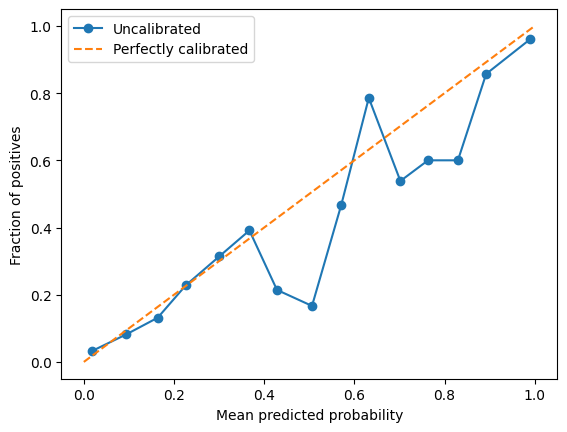

In [240]:
#// BEGIN_TODO [STEP_3] Visualize calibration of uncalibrated model (1 point)
from sklearn.calibration import calibration_curve


prob_true, prob_pred = calibration_curve(y_binary_test, uncalibrated_p, n_bins=15)

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()


observation_uncalibrated = """
The classifier is not calibrated.
Around 0.5 and 0.8 predicted probability, it's overestimating.
Around 0.6 predicted probability, it's underestimating.
"""

In [241]:
#// END_TODO [STEP_3]

#### Step 4

Choose a calibration metric and assign its name to a string variable `binary_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `binary_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `binary_metric_decision` (max 400 characters).

In [242]:
#// BEGIN_TODO [STEP_4] Choose a calibration metric (1 point)

binary_metric_choice = "MCE"

binary_metric_motivation = "MCE is used as the metric because it is a good metric for imbalanced datasets, which is the case for this dataset. It is also a good metric for binary classification problems."

In [243]:
#// END_TODO [STEP_4]

#### Step 5

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `binary_metric`.

Measure the calibration error of your model on `X_test` and `y_binary_test` and assign the result to the variable `binary_uncalibrated`.

In [244]:
#// BEGIN_TODO [STEP_5] Implement the calibration metric (1 point)

# Implementation of Maximum Calibration Error
class MCE:
    def score(self, p, y):
        prob_true, prob_pred = calibration_curve(y, p, n_bins=10)
        return np.max(np.abs(prob_pred - prob_true))

binary_metric = MCE()
binary_uncalibrated = binary_metric.score(uncalibrated_p, y_binary_test)
print("Calibration error: ", binary_uncalibrated)

Calibration error:  0.21738096287308067


In [245]:
#// END_TODO [STEP_5]

## Calibrate the classifer

#### Step 6

Implement at least two calibration methods. Each calibration method should be a Python class with the following methods:

- `fit(self, p, y)`, where 
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It fits the calibration model and returns a reference to `self`.
- `predict_proba(self, p)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with confidence estimates of the *positive class* for $N$ samples.
    - It returns an `np.ndarray` of shape $[N,]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `binary_calibrators`.

Calibration error:  0.46928296954618676


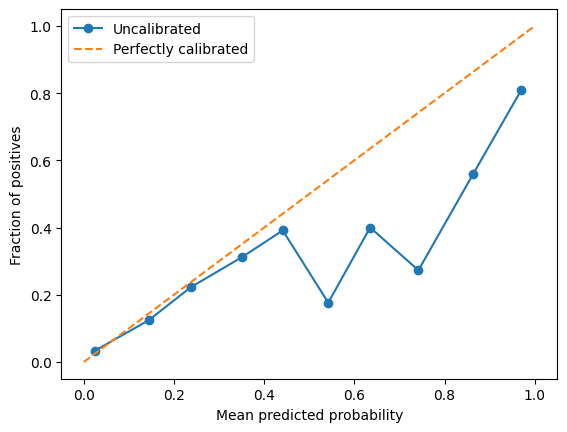

Calibration error:  0.1875807833452855


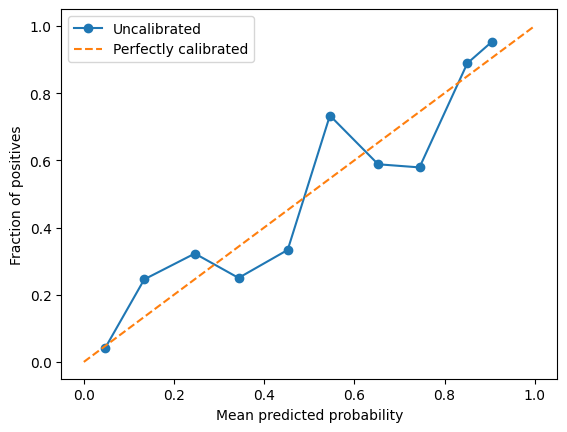

In [246]:
#// BEGIN_TODO [STEP_6] Implement calibration methods (1 point)

# The two chosen calibration methods are: Isotonic Regression and Platt Scaling

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

class IsotonicCalibration:
    def __init__(self):
        self.model = IsotonicRegression(out_of_bounds='clip')

    def fit(self, p, y):
        prob_true, prob_pred = calibration_curve(y, p, n_bins=6)
        self.model.fit(prob_pred, prob_true)
        return self

    def predict_proba(self, p):
        return self.model.predict(p)

class PlattScaling:
    def __init__(self):
        self.model = LogisticRegression(C=1e-1)

    def fit(self, p, y):
        self.model.fit(p.reshape(-1, 1), y)
        return self

    def predict_proba(self, p):
        return self.model.predict_proba(p.reshape(-1, 1))[:, 1]


def test_calibrator(model):
    model.fit(tr_uncalibrated_p, y_binary_train)
    calibrated_p = model.predict_proba(uncalibrated_p)

    binary_score = binary_metric.score(calibrated_p, y_binary_test)
    print("Calibration error: ", binary_score)

    # Plot the new probabilities
    prob_true, prob_pred = calibration_curve(y_binary_test, calibrated_p, n_bins=10)

    # Plot the calibration curve
    plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()

ir = IsotonicCalibration()
ps = PlattScaling()

test_calibrator(ir)
test_calibrator(ps)

In [247]:
#// END_TODO [STEP_6]

#### Step 7

Evaluate the performance of your calibration methods. Describe your observations in the variable `observation_calibrators` (max 2000 characters).

In [248]:
#// BEGIN_TODO [STEP_7] Evaluate the calibration method (1 point)
observation_calibrators = """
The predicted probabilities are more balanced and more calibrated and MCE is lower.
"""

In [249]:
#// END_TODO [STEP_7]

#### Step 8

Let's evaluate your selected calibration method on the output from different classifier, stored in the `./data/wafer_calibration.pkl` pickle file.

In [250]:
with open('./data/wafer_calibration.pkl', 'rb') as f:
    p_calib_train, p_calib_test, y_calib_train, y_calib_test = pickle.load(f)

`p_calib_train` and `p_calib_test` contain the confidence estimates of a classifier (divided into a training and test set), and `y_calib_train` and `y_calib_test` contain the corresponding true labels.

Retrain your calibration methods on `p_calib_train` and `y_calib_train`. Use `p_calib_test` and `y_calib_test` to evaluate your methods. Describe your observations in the variable `observation_other` (max 800 characters).

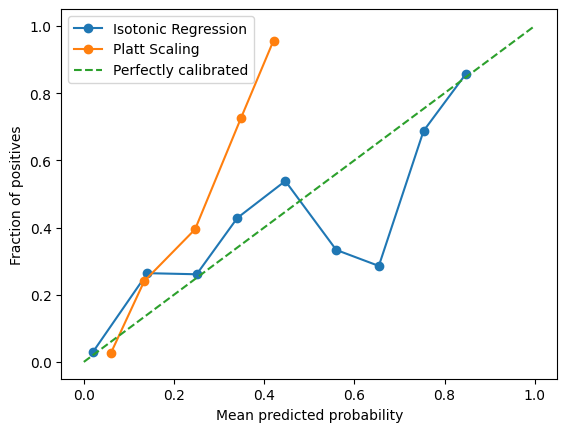

MCE for Isotonic Regression:  0.36853781139736264
MCE for Platt Scaling:  0.5357763411262964


In [251]:
#// BEGIN_TODO [STEP_8] Evaluate the calibration method on another classifier (1 point)

# Retrain your calibration methods on p_calib_train and y_calib_train. Use p_calib_test and y_calib_test to evaluate your methods.

#Retrain the calibration methods on p_calib_train and y_calib_train
ir = IsotonicCalibration()
ps = PlattScaling()

ir.fit(p_calib_train, y_calib_train)
ps.fit(p_calib_train, y_calib_train)

ir_y_calibrated = ir.predict_proba(p_calib_test)
ps_y_calibrated = ps.predict_proba(p_calib_test)

# Plot the new probabilities
prob_true_ir, prob_pred_ir = calibration_curve(y_calib_test, ir_y_calibrated, n_bins=10)
prob_true_ps, prob_pred_ps = calibration_curve(y_calib_test, ps_y_calibrated, n_bins=10)

# Plot the calibration curve
plt.plot(prob_pred_ir, prob_true_ir, marker='o', label='Isotonic Regression')
plt.plot(prob_pred_ps, prob_true_ps, marker='o', label='Platt Scaling')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()


#Compute MCE
mce_ir = binary_metric.score(ir_y_calibrated, y_calib_test)
mce_ps = binary_metric.score(ps_y_calibrated, y_calib_test)
print("MCE for Isotonic Regression: ", mce_ir)
print("MCE for Platt Scaling: ", mce_ps)


observation_other = """
The results are worse than the training set. The probabilities are not well calibrated.
"""


In [252]:
#// END_TODO [STEP_8]

#### Step 9

Choose your favorite calibration method. Assign the instantiated class implementing your chosen calibration method to the variable `binary_calibrator` and its name to a string variable `binary_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `binary_calibrator_motivation` (max 800 characters).

Apply the calibration method to the confidence estimates in `p_calib_test` and assign the calibrated confidence estimates to `q_calib_test` (an `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated confidence estimates in `q_calib_test` and assign the result to the variable `binary_calibrated`.

In [253]:
#// BEGIN_TODO [STEP_9] Choose a calibration method (1 point)

isotonic = IsotonicCalibration()
binary_calibrator_choice = "isotonic"

binary_calibrator_motivation = """
More calibrated and lower MCE.
"""

isotonic.fit(p_calib_train, y_calib_train)
q_calib_test = isotonic.predict_proba(p_calib_test)

binary_calibrated = MCE().score(q_calib_test, y_calib_test)

print("Calibration error: ", binary_calibrated)



Calibration error:  0.36853781139736264


In [254]:
#// END_TODO [STEP_9]

#### Leaderboard (binary)

Your grade for this assignment will be based on your position on two leaderboards, one for binary calibration and one for multi-class calibration. Your submission to the leaderboards will be automatically computed based on this notebook after you submit it to the "Assignment 1: Calibration" assignment on Canvas.

You may submit as many times as you like before the deadline. We will try to update the leaderboard regularily. Your latest submission at the moment the leaderboard is computed will count.

The data for the binary leaderboard is stored in the `./data/wafer_leaderboard_binary.pkl` pickle file.

In [255]:
with open('./data/wafer_leaderboard_binary.pkl', 'rb') as f:
    p_binary_leaderboard = pickle.load(f)

The data in `p_binary_leaderboard` comes from a similar distribution to the binary calibration data in `./data/wafer_calibration.pkl`.

Apply your `binary_calibrator` to the confidence estimates in `p_binary_leaderboard`. Assign the resulting calibrated confidence esimates to `q_binary_leaderboard`.

Assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to `None`.

In [256]:
#// BEGIN_TODO [LEADERBOARD_BINARY] Join the leaderboard

"""The data in p_binary_leaderboard comes from a similar distribution to the binary calibration data in ./data/wafer_calibration.pkl.
Apply your binary_calibrator to the confidence estimates in p_binary_leaderboard. Assign the resulting calibrated confidence esimates to q_binary_leaderboard.
Assign a nickname to the string variable leaderboard_nickname that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to None."""


leaderboard_nickname = "KEv3"

isotonic = IsotonicCalibration()
isotonic.fit(p_calib_train, y_calib_train)
q_binary_leaderboard = isotonic.predict_proba(p_binary_leaderboard)




In [257]:
#// END_TODO [LEADERBOARD_BINARY]

Run the following cell to create a file with your leaderboard submission.

In [258]:
if leaderboard_nickname is not None:

    # perform some sanity checks
    assert isinstance(group_number, int), "group_number is not an integer"
    assert isinstance(leaderboard_nickname, str), "leaderboard_nickname is not a string"
    assert isinstance(q_binary_leaderboard, np.ndarray), "q_binary_leaderboard is not an np.ndarray"
    assert q_binary_leaderboard.shape == p_binary_leaderboard.shape, "q_binary_leaderboard has wrong shape"

    # export the solution to a .json file
    with open("leaderboard_binary.json", "w") as file:
            json.dump({
                "group_number": group_number,
                "leaderboard_nickname": leaderboard_nickname,
                "q_binary_leaderboard": q_binary_leaderboard.tolist()
            }, file)

If all went well, a `leaderboard_binary.json` file should have been created in the same directory as this notebook. **Check that it is created, as this file will be used for your leaderboard submission!**

## Extend to multi-class classification

So far we have assumed a binary classification task. In this part you will implement a calibration metric and method that is applicable to multi-class classification.

#### Step 10

For evaluating the multi-class calibration metric and method, train a classifier on the multi-class wafer map data `X_train` and `y_train` that was loaded earlier. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class and the confidence estimate for each class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor.

Evaluate your trained model on the test set `X_test` and `y_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_multiclass_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimates in the variables `multi_uncalibrated_y` and `multi_uncalibrated_p`, respectively:

- `multi_uncalibrated_y` should be a `np.ndarray` of shape $[N,K]$, with the predicted classes (one-hot encoded), where $N$ is the number of samples and $K$ is the number of classes, i.e. `multi_uncalibrated_y[n][k]` is 1 if the classifier predicted class `k`, otherwise it is 0, 
- `multi_uncalibrated_p` should be a `np.ndarray` of shape $[N,K]$, with the corresponding confidence estimates, i.e. `multi_uncalibrated_p[n][k]` is the classifier's confidence that the predicted class should be `k`.

> **IMPORTANT:** For the wafer dataset $K = 9$ and the class indeces should correspond to the classes listed in section **Load the data**.

In [305]:
#// BEGIN_TODO [STEP_10] Train a multi-class classifier (1 point)

observation_multiclass_classifier = """ The accuracy is good (0.92) but by examining the F1-score for macro avg is low (0.42). The results are obtained after balancing the dataset because for some classes were very few datapoints."""


class_map = {
    0: 0,
    1: 1,
    3: 2,
    5: 3,
    6: 4,
    7: 5
}


# angles = [90, 180, 270]
#
#
# # Extract samples of class 0
#
# y_train_zeros = (y_train == 0)
# X_train_zeros = X_train[y_train_zeros]
#
# # Extract samples of the rest of the classes
# y_train_mc = (y_train != 0)
# X_train_mc = X_train[y_train_mc]
#
# y_train_zeros = y_train[y_train_zeros]
# y_train_mc = y_train[y_train_mc]
#
# print(X_train.shape, X_train_mc.shape, X_train_zeros.shape)
# print(y_train.shape, y_train_mc.shape, y_train_zeros.shape)
#
#
# unique, counts = np.unique(y_train_mc, return_counts=True)
# print(dict(zip(unique, counts)))
#
# unique, counts = np.unique(y_train_zeros, return_counts=True)
# print(dict(zip(unique, counts)))
#
# # remove values where class is 0, so that there is maximum of 400 values which correspond to 0.
#
# y_train_mc_rotated = y_train_mc.copy()
# X_train_mc_copy = X_train_mc.copy()
#
# # Increase the training dataset by rotating the images
# for angle in angles:
#     X_train_rotated = np.rot90(X_train_mc_copy, k=angle, axes=(1, 2))
#
#
#     X_train_mc = np.concatenate((X_train_mc, X_train_rotated), axis=0)
#     y_train_mc = np.concatenate((y_train_mc, y_train_mc_rotated), axis=0)
#
#
# # Supersample images, bu flipping the images horizontally, vertically and both
# X_train_flipped = np.flip(X_train_mc, axis=2)
# X_train_flipped_v = np.flip(X_train_mc, axis=1)
# X_train_flipped_both = np.flip(X_train_flipped, axis=1)
#
# X_train_mc = np.concatenate((X_train_mc, X_train_flipped, X_train_flipped_v, X_train_flipped_both), axis=0)
# y_train_mc = np.concatenate((y_train_mc, y_train_mc, y_train_mc, y_train_mc), axis=0)
#
#
# y_train_mc = np.concatenate((y_train_mc, y_train_zeros), axis=0)
# X_train_mc = np.concatenate((X_train_mc, X_train_zeros), axis=0)
#
# permutation = np.random.permutation(len(y_train_mc))
#
# y_train_mc = y_train_mc[permutation]
# X_train_mc = X_train_mc[permutation]
#
#

X_train_mc = X_train.copy()
y_train_mc = y_train.copy()

X_train_reshaped = X_train_mc.reshape(X_train_mc.shape[0], X_train_mc.shape[1] * X_train_mc.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])



map_func = np.vectorize(lambda x: class_map[x])
mapped_y_train = map_func(y_train_mc)
mapped_y_test = map_func(y_test)

unique, counts = np.unique(mapped_y_train, return_counts=True)
print(dict(zip(unique, counts)))



{0: 3744, 1: 47, 2: 161, 3: 138, 4: 36, 5: 34}


In [306]:
dict(zip(*np.unique(mapped_y_test, return_counts=True)))

{0: 1847, 1: 15, 2: 79, 3: 84, 4: 20, 5: 20}

In [307]:
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# # Grid search for best hyperparameters
#
# # defining parameter range
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
#
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
#
# # fitting the model for grid search
# grid.fit(X_train_reshaped[0:601], mapped_y_train[0:601])
#
# # print best parameter after tuning
# print(grid.best_params_)
#
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)
# grid_predictions = grid.predict(X_test_reshaped)
#
# # print classification report
# print(classification_report(mapped_y_test, grid_predictions))



# Train a multi-class classifier on the training set X_train and y_train

model = OneVsRestClassifier(RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200)).fit(X_train_reshaped, mapped_y_train)

multi_uncalibrated_y = model.predict(X_test_reshaped)
multi_uncalibrated_p = model.predict_proba(X_test_reshaped)

train_multi_uncalibrated_y = model.predict(X_train_reshaped)
train_multi_uncalibrated_p = model.predict_proba(X_train_reshaped)

print(classification_report(mapped_y_test, multi_uncalibrated_y))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1847
           1       1.00      0.07      0.12        15
           2       0.72      0.16      0.27        79
           3       0.83      0.06      0.11        84
           4       1.00      0.20      0.33        20
           5       0.00      0.00      0.00        20

    accuracy                           0.91      2065
   macro avg       0.74      0.25      0.30      2065
weighted avg       0.89      0.91      0.87      2065



C:\Users\Berkay_HP\Desktop\Enes\TUe\ML Ind\assignment_calibration\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Berkay_HP\Desktop\Enes\TUe\ML Ind\assignment_calibration\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Berkay_HP\Desktop\Enes\TUe\ML Ind\assignment_calibration\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [308]:
#// END_TODO [STEP_10]

#### Step 11

Choose a calibration metric and assign your choice to a string variable `multi_calibration_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `multi_calibration_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `multi_calibration_decision` (max 200 characters).

In [309]:
#// BEGIN_TODO [STEP_11] Choose a multi-class calibration metric (1 point)

multi_calibration_motivation = "MCE"

In [310]:
#// END_TODO [STEP_11]

#### Step 12

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `multi_metric`.

Measure the calibration error of your model on `X_test` and `y_test` and assign the result to the variable `multi_uncalibrated`.

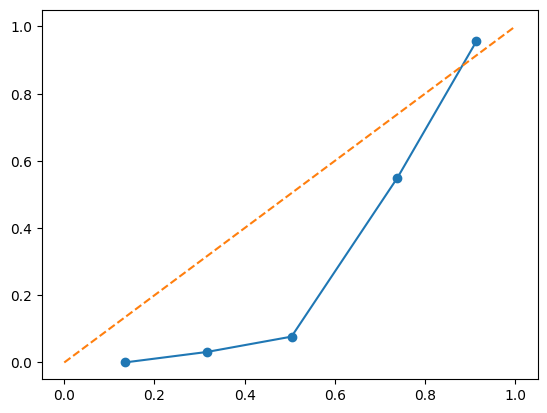

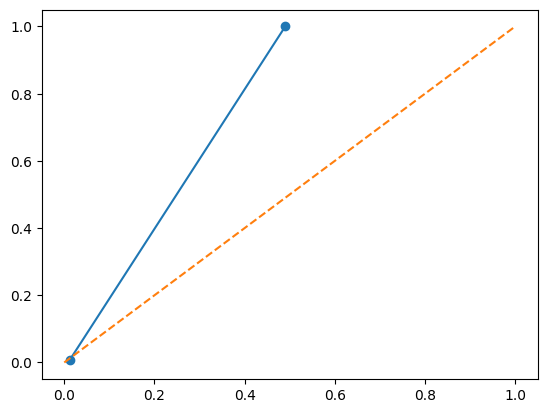

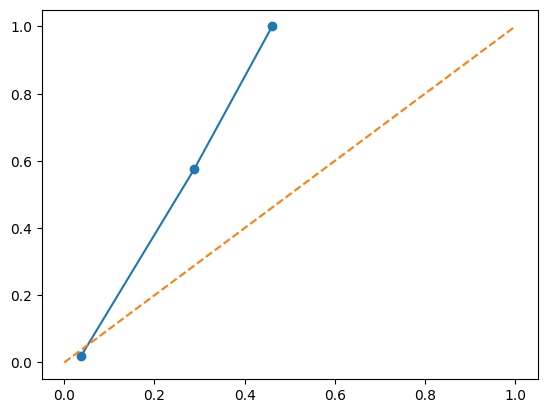

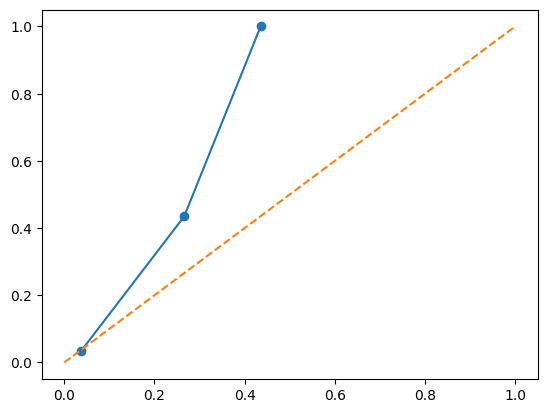

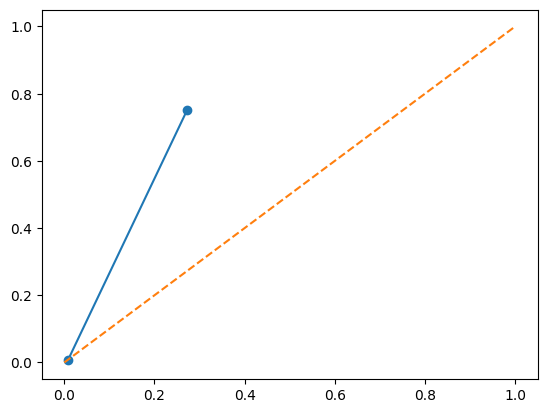

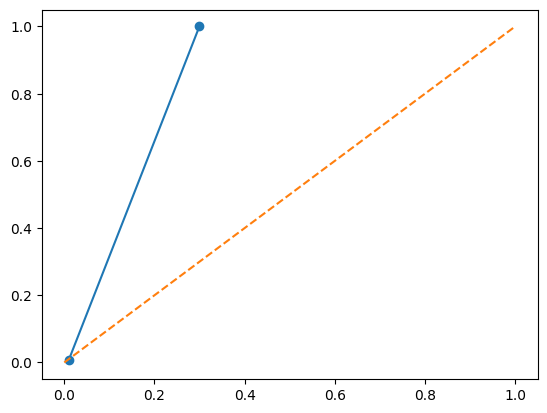

Calibration error:  0.5364928617802281


In [311]:
#// BEGIN_TODO [STEP_12] Implement the multi-class calibration metric (1 point)

# Implementation of Maximum Calibration Error for Multi-Class
class MCEMulti:
    def score(self, p, y):
        res = []
        for i in range(p.shape[1]):
            prob_true, prob_pred = calibration_curve(y[:, i], p[:, i], n_bins=5)
            error = np.max(np.abs(prob_pred - prob_true))
            res.append(error)

            #plot the calibration curve
            plt.plot(prob_pred, prob_true, marker='o', label='Class ' + str(i))
            plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
            plt.show()

        return sum(res) / len(res)

multi_metric = MCEMulti()

# One-hot encode the true labels
y_test_one_hot = np.zeros((mapped_y_test.size, mapped_y_test.max() + 1))
y_test_one_hot[np.arange(mapped_y_test.size), mapped_y_test] = 1

y_train_one_hot = np.zeros((mapped_y_train.size, mapped_y_train.max() + 1))
y_train_one_hot[np.arange(mapped_y_train.size), mapped_y_train] = 1

multi_uncalibrated_score = multi_metric.score(multi_uncalibrated_p, y_test_one_hot)
print("Calibration error: ", multi_uncalibrated_score)

In [312]:
#// END_TODO [STEP_12]

#### Step 13

Implement at least one calibration method. Each calibration method should be a Python class with the following methods:

- `fit(self, p, y)`: where 
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It fits the calibration model and returns a reference to `self`.

- `predict_proba(self, p)`: where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - It returns an `np.ndarray` of shape $[N,K]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `multi_calibrators`.

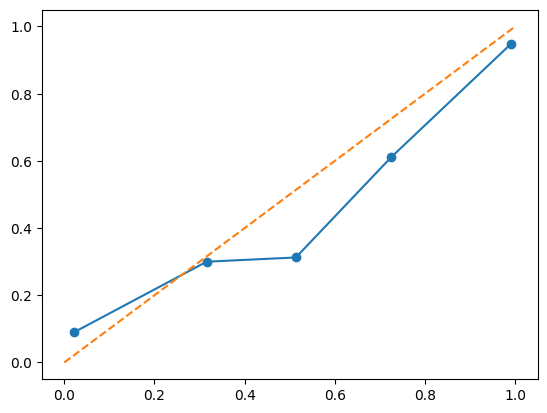

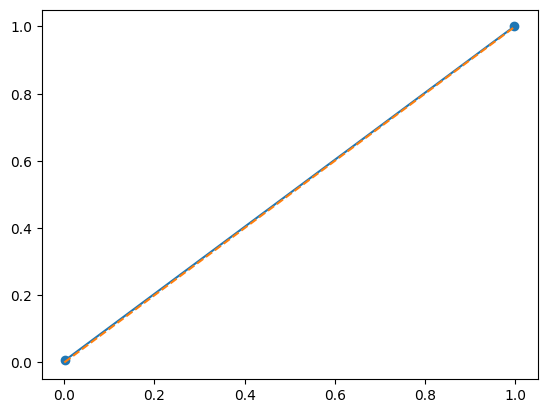

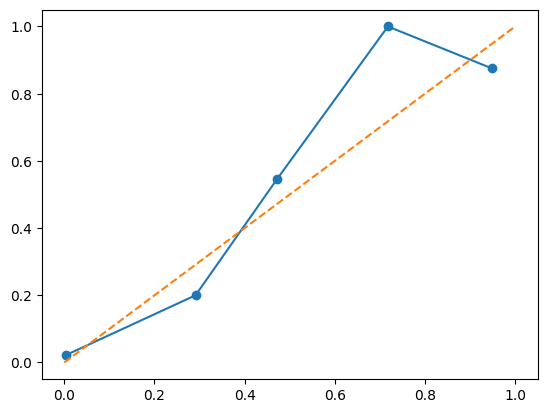

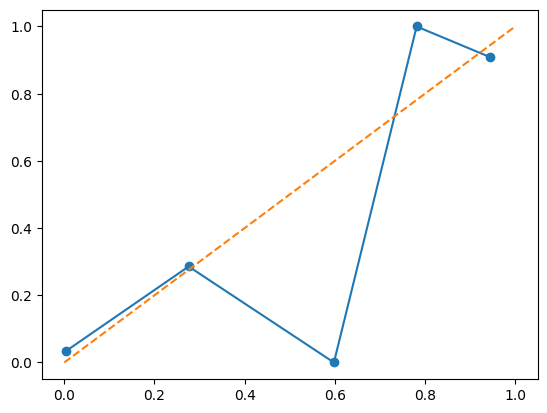

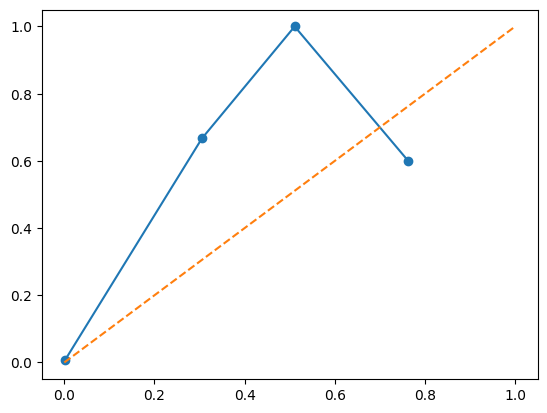

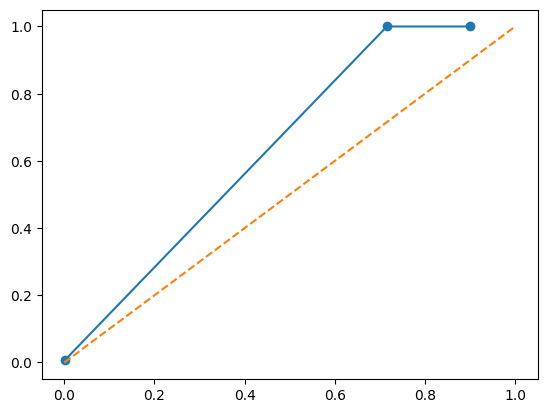

Calibration error:  0.3099116462844889


In [320]:
#// BEGIN_TODO [STEP_6] Implement calibration methods (1 point)

# The two chosen calibration methods are: Isotonic Regression and Platt Scaling

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

class TemperatureScaling:
    def __init__(self):
        self.models = [LogisticRegression(C=1e1) for _ in range(6)]

    def fit(self, p, y):
        for i in range(6):
            self.models[i].fit(p[:, i].reshape(-1, 1), y[:, i])
        return self

    def predict_proba(self, p):
        predictions = np.zeros((p.shape[0], 6))
        for i in range(6):
            predictions[:, i] = self.models[i].predict_proba(p[:, i].reshape(-1, 1))[:, 1]
        return predictions

class OneVsAllCalibration:
    def __init__(self):
        self.models = None

    def fit(self, p, y):
        n_samples, n_classes = p.shape
        self.models = []

        for i in range(n_classes):
            # Create binary labels for class i
            binary_y = (y[:, i] == 1).astype(int)
            # Train logistic regression model for class i
            model = LogisticRegression(C=1e1, solver='lbfgs')
            model.fit(p, binary_y)
            self.models.append(model)

        return self

    def predict_proba(self, p):
        n_samples = p.shape[0]
        n_classes = len(self.models)
        calibrated_proba = np.zeros((n_samples, n_classes))

        for i in range(n_classes):
            # Predict probabilities using the binary classifier for class i
            binary_proba = self.models[i].predict_proba(p)[:, 1]
            # Assign calibrated probabilities for class i
            calibrated_proba[:, i] = binary_proba

        return calibrated_proba


multi_metric = MCEMulti()


multi_calibrated_p = OneVsAllCalibration().fit(train_multi_uncalibrated_p, y_train_one_hot)\
                        .predict_proba(multi_uncalibrated_p)

# print(multi_calibrated_p)

multi_calibrated_p_2 = TemperatureScaling().fit(train_multi_uncalibrated_p, y_train_one_hot)\
                        .predict_proba(multi_uncalibrated_p)

# print(multi_calibrated_p_2)

multi_calibrated = multi_metric.score(multi_calibrated_p, y_test_one_hot)
print("Calibration error: ", multi_calibrated)


In [272]:
#// END_TODO [STEP_13]

#### Step 14

Evaluate the performance of your calibration methods. Assign the instantiated class implementing your chosen calibration method to the variable `multiclass_calibrator` and its name to a string variable `multiclass_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `multiclass_calibrator_motivation` (max 800 characters).

Apply the chosen calibration method to your model on the test data `X_test` and assign the calibrated confidence estimates to `q_multi_test` (an `np.ndarray` of shape $[N,K]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated model and assign the result to the variable `multi_calibrated`.

In [273]:
#// BEGIN_TODO [STEP_14] Choose a multi-class calibration method (1 point)

q_multi_test = model.predict_proba(X_test_reshaped)





In [274]:
#// END_TODO [STEP_14]

#### Multi-class leaderboard

The `./data/wafer_leaderboard_multiclass.pkl` pickle file contains the data that you can use for training your `multiclass_calibrator`, and the data for computing your submission to the leaderboard data.

In [275]:
with open('./data/wafer_leaderboard_multiclass.pkl', 'rb') as f:
    p_multiclass_leaderboard_train, y_multiclass_leaderboard_train, p_multiclass_leaderboard = pickle.load(f)


Train your `multiclass_calibrator` on the confidence estimates in `p_multiclass_leaderboard_train` and the corresponding true class labels in `y_multiclass_leaderboard_train`.

Apply your `multiclass_calibrator` to the confidence estimates in `p_multiclass_leaderboard`. Assign the resulting calibrated confidence esimates to `q_multiclass_leaderboard`.

Assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score. If you do not wat to participate on the leaderboard, set it to `None`.

In [276]:
#// BEGIN_TODO [LEADERBOARD_MULTICLASS] Join the leaderboard

multiclass_calibrator = TemperatureScaling()


y_multiclass_leaderboard_train = map_func(y_multiclass_leaderboard_train)
#one hot encode y
ohe_y_multiclass_leaderboard_train = np.zeros((y_multiclass_leaderboard_train.size, y_multiclass_leaderboard_train.max() + 1))
ohe_y_multiclass_leaderboard_train[np.arange(y_multiclass_leaderboard_train.size), y_multiclass_leaderboard_train] = 1


multiclass_calibrator.fit(p_multiclass_leaderboard_train, ohe_y_multiclass_leaderboard_train)

q_multiclass_leaderboard = multiclass_calibrator.predict_proba(p_multiclass_leaderboard)

# map the classes back to the original classes
# map 0th index to 0, 1st index to 1, 2nd index to 3, 3rd index to 5, 4th index to 6, 5th index to 7
mapping = {0: 0, 1: 1, 2: 3, 3: 5, 4: 6, 5: 7}


# New array with increased 2nd dimension
result = np.zeros((q_multiclass_leaderboard.shape[0], q_multiclass_leaderboard.shape[1] + 3))

# Copy elements from the original array to the new array with the desired mapping
for i in range(q_multiclass_leaderboard.shape[0]):
    for j in range(q_multiclass_leaderboard.shape[1]):
        if j in (2, 4, 8):
            result[i, mapping[j]] = 0
        else:
            result[i, mapping.get(j, j)] = q_multiclass_leaderboard[i, j]

q_multiclass_leaderboard = result



leaderboard_nickname = "KEv3"



In [ ]:
#// END_TODO [LEADERBOARD_MULTICLASS]
print(q_multiclass_leaderboard.shape, p_multiclass_leaderboard.shape)

Run the following cell to create a file with your leaderboard submission.

In [ ]:
if leaderboard_nickname is not None:
    
    # perform some sanity checks
    assert isinstance(group_number, int), "group_number is not an integer"
    assert isinstance(leaderboard_nickname, str), "leaderboard_nickname is not a string"
    assert isinstance(q_multiclass_leaderboard, np.ndarray), "q_multiclass_leaderboard is not an np.ndarray"
    assert q_multiclass_leaderboard.shape == p_multiclass_leaderboard.shape, "q_multiclass_leaderboard has wrong shape"

    # export the solution to a .json file
    with open("leaderboard_multiclass.json", "w") as file:
        json.dump({
            "group_number": group_number,
            "leaderboard_nickname": leaderboard_nickname,
            "q_multiclass_leaderboard": q_multiclass_leaderboard.tolist()
        }, file)

If all went well, a `leaderboard_multiclass.json` file should have been created in the same directory as this notebook.  **Check that it is created, as this file will be used for your leaderboard submission!**

#### Step 15

A well calibrated classifier can also be used to identify whether a test sample is out-of-distribution, i.e. if it is very different from the data that the classifier was trained on. The `ood.pkl` file contains several out-of-distribution samples.

In [ ]:
with open('./data/ood.pkl', 'rb') as f:
    X_ood = pickle.load(f)
    
plt.imshow(X_ood[0]);

Evaluate your classifier and calibration method on the data in `X_ood`. Describe your observations in a string variable `observation_ood` (max 1000 characters). Describe one drawback of this approach for identifying out-of-distribution samples in a string variable `drawback_ood` (max 500 characters).

In [279]:
#// BEGIN_TODO [STEP_15] (1 point)

X_ood = X_ood.reshape(X_ood[0], X_ood[1] * X_ood[2])


pred = model.predict(X_ood)
pred_proba = model.predict_proba(X_ood)

print(pred)
print(pred_proba)


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
#// END_TODO [STEP_15]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`. Please fill in the average among all group members.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]

import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult. Please fill in the average among all group members.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)

#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### Which Machine Learning-related courses did you complete (TUE/workshop/online/etc.)?

Assign a string to variable `feedback_courses`, listing any ML courses any of your group members followed.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 points)

#// END_FEEDBACK [Feedback_3]

assert isinstance(feedback_courses, str), "Please assign a string to variable feedback_courses"

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 points)

#// END_FEEDBACK [Feedback_4]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]